In [87]:
import sys
import fitsio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as pl
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

## Where are the FFIs?

In [88]:
# Get the filenames of all Sector 5 Camera 1-4 FFIs
import glob
PATH = "/media/gb/Samsung_T5/tess-ffi/s5"
filenames = sorted(glob.glob(PATH + '/*s0005-1-4*'))

## Where is Sedna?

In [90]:
sys.path.append("/home/gb/dev/shifty/shifty")
import known
ra, dec = known.Known()._interpolate_radec_for_sedna(2458438.62600)

## How to read and stack FFI images?

In [46]:
class TessLoader():
    """Load a patch of FFI data from TESS FFI files.
    """
    
    # TESS Cameras provide 2048x2048 science pixels
    # with the following x/y coordinate ranges:
    XRANGE = (44, 2092)
    YRANGE = (0, 2048)
    
    def __init__(self, filenames):
        self.filenames = filenames

    def _patch_to_limits(self, patch=1, patchsize=512):
        """Returns the corners (xmin, xmax, ymin, ymax) of a patch."""
        patch_x = int(patch % np.floor(2048 / patchsize))
        patch_y = int(np.floor((patch * patchsize) / 2048))
        return (self.XRANGE[0] + patch_x * patchsize,
                self.XRANGE[0] + (patch_x + 1) * patchsize,
                self.YRANGE[0] + patch_y * patchsize,
                self.YRANGE[0] + (patch_y + 1) * patchsize)
        
    def get_patch(self, patch=1, patchsize=512):
        """Returns an `ImageData` object containing the pixel data in a patch."""
        xmin, xmax, ymin, ymax = self._patch_to_limits(patch=patch, patchsize=patchsize)        
        images = np.empty((len(self.filenames), ymax-ymin, xmax-xmin))
        headers = []
        for idx, fn in tqdm(enumerate(self.filenames), total=len(self.filenames), desc='Reading FFIs'):
            with fitsio.FITS(fn) as fts:
                images[idx] = fts[1][ymin:ymax, xmin:xmax]
                headers.append(fts[1].read_header())
        return ImageData(images, headers)


class ImageData():
    """Holds a set of imaging data to stack."""
    def __init__(self, data, headers=None):
        """
        Parameters
        ----------
        data : ndarray
            3D numpy array of shape (images, columns, rows)
        headers : list of headers
            Headers associated with each image.
        """
        self.data = data
        self.headers = headers
    
    def __len__(self):
        return self.data.shape[0]
    
    def stack(self, shifts=None):
        """
        Parameters
        ----------
        shifts : tuple of tuples (x, y)
            e.g., ((0,0), (-1,3), ...)
        """
        if shifts is None:
            shifts = zip(np.zeros(len(self)), np.zeros(len(self)))

        def z2n(val):
            """Converts 0 to None, which we need for indexing below."""
            if val == 0:
                return None
            return val

        stack = np.zeros(self.data.shape[1:])
        for idx, shift in enumerate(shifts):
            if (shift[0] >= 0) and (shift[1] >= 0):
                stack[shift[1]:, shift[0]:] += self.data[idx, :z2n(-shift[1]), :z2n(-shift[0])]
            elif (shift[0] >= 0) and (shift[1] < 0):
                stack[:-shift[1], shift[0]:] += self.data[idx, shift[1]:, :z2n(-shift[0])]
            elif (shift[0] < 0) and (shift[1] < 0):
                stack[:-shift[1], :-shift[0]] += self.data[idx, shift[1]:, shift[0]:]
            elif (shift[0] < 0) and (shift[1] >= 0):
                stack[shift[1]:, :-shift[0]] += self.data[idx, :z2n(-shift[1]), shift[0]:]
        return stack        

In [55]:
def get_sedna_shifts(headers):
    x, y = [], []
    ralist, declist = [], []
    times = []
    for hdr in headers:
        jd = hdr['BJDREFI'] + hdr['TSTART']
        ra, dec = known.Known()._interpolate_radec_for_sedna(jd)
        crd = SkyCoord(ra, dec, unit='deg')
        pixel = WCS(hdr).world_to_pixel(crd)
        x.append(int(pixel[0]))
        y.append(int(pixel[1]))
        ralist.append(ra)
        declist.append(dec)
        times.append(jd)
    return np.array(tuple(zip(x, y))), np.array(tuple(zip(ralist, declist))), times

In [75]:
data = TessLoader(filenames).get_patch(10)

Reading FFIs: 100%|██████████| 1196/1196 [00:39<00:00, 30.57it/s]


In [76]:
shifts, radec, times = get_sedna_shifts(data.headers)
shifts -= (1540, 1100)

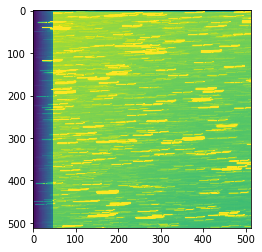

In [85]:
#shifts = ((-6, -4), (-2, -2), (0, 0), (+2, +2), (+4, +6))
mystack = data.stack(shifts)
pl.imshow(mystack, vmin=np.nanmin(mystack), vmax=np.nanmax(mystack)*0.05)